In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

In [2]:
pdb='/home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.pdb'
trajectory='/home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.s10.dcd'
xray_CA_pdb='/home/f0042vb/CHEM101.6/week5/Villin_Lab/2f4K.xray.CA.pdb'
outdir='/home/f0042vb/CHEM101.6/week5/output'
if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /home/f0042vb/CHEM101.6/week5/output
pdb: /home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.pdb
trjaectory: /home/f0042vb/CHEM101.6/week5/Villin_Lab/2F4K.protein.s10.dcd


In [3]:
stride_sel=5
trj = md.load(trajectory, top=pdb,stride=stride_sel)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames
trj_length=125
time=np.linspace(0,125,n_frames)

nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=(' %s' % [residue for residue in trj.topology.residues])
resname=(' %s' % [residue.name for residue in trj.topology.residues])
resindex=(' %s' % [residue.index for residue in trj.topology.residues])
res_num=(' %s' % [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)

** SYSTEM INFO **

Number of atoms: 577

Number of residues: 35

Number of frames: 12559

Starting frame: 0

Last frame: 12559

sequence:  [LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76, LEU42, SER43, ASP44, GLU45, ASP46, PHE47, LYS48, ALA49, VAL50, PHE51, GLY52, MET53, THR54, ARG55, SER56, ALA57, PHE58, ALA59, ASN60, LEU61, PRO62, LEU63, TRP64, NLE65, GLN66, GLN67, HIS68, LEU69, NLE70, LYS71, GLU72, LYS73, GLY74, LEU75, PHE76]

residue names:  ['LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'ALA', 'PHE', 'ALA', 'ASN', 'LEU', 'PRO', 'LEU', 'TRP', 'NLE', 'GLN', 'GLN', 'HIS', 'LEU', 'NLE', 'LYS', 'GLU', 'LYS', 'GLY', 'LEU', 'PHE', 'LEU', 'SER', 'ASP', 'GLU', 'ASP', 'PHE', 'LYS', 'ALA', 'VAL', 'PHE', 'GLY', 'MET', 'THR', 'ARG', 'SER', 'A

In [4]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)

xray_CA = md.load_pdb(xray_CA_pdb)
top_xray = xray_CA.topology
top_xray
residue_xray=[]
for res in top_xray.residues: 
    residue_xray.append(res.resSeq)
resid_xray=np.asarray(residue_xray)
resid_xray

array([42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58,
       59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75,
       76])

In [5]:
trjCA = md.load(trajectory, top=pdb,stride=stride_sel)
CA=top.select("name CA")
trjCA.restrict_atoms(CA)
trjCA.center_coordinates()

<mdtraj.Trajectory with 12559 frames, 35 atoms, 35 residues, and unitcells at 0x7bace874d910>

In [6]:
native_distance_matrix1D=[]
for i in range(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   #print(i,j)
   dist=md.compute_distances(xray_CA,[[i,j]])[0][0]
   native_distance_matrix1D.append(dist)

#Convert to Angstrom
native_distance_matrix1D=np.asarray(native_distance_matrix1D)*10

In [7]:
Native_Contacts=np.where(native_distance_matrix1D<10)
Native_Contact_Distances=native_distance_matrix1D[Native_Contacts]
np.shape(Native_Contact_Distances)

(148,)

In [8]:
from tqdm import trange

traj_CA_distance_matrix1D=[]
for i in trange(0,34):
 for j in range(0, 34):
  if(abs(i-j)>7):
   dist=md.compute_distances(trjCA,[[i,j]])[:,0]
   traj_CA_distance_matrix1D.append(dist)

#Convert to Angstrom
traj_CA_distance_matrix1D=np.asarray(traj_CA_distance_matrix1D)*10
Traj_Native_Contact_Distances=traj_CA_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]




100%|██████████| 34/34 [02:30<00:00,  4.43s/it]


In [9]:
#Now Lets Filter Our Distances based on only the "Native Portion of the Trajectory" and recompute Q
rmsd = md.rmsd(trjCA,xray_CA)
native_frames=np.where(rmsd<0.25)[0]

trj_native_distances=traj_CA_distance_matrix1D[:,native_frames]

averages=np.average(trj_native_distances,axis=1)
Native_Contacts=np.where(averages<10.0)[0]

Native_CA_Distances=native_distance_matrix1D[Native_Contacts]
Traj_CA_Distnaces=traj_CA_distance_matrix1D[Native_Contacts]

#Expand Native Distance Matrix so that its the same number of frames as the trajectory
Native_Contact_Distances_nframes=np.zeros(np.shape(Traj_CA_Distnaces))
for i in range(0,len(Native_CA_Distances)):
 Native_Contact_Distances_nframes[i]=Native_CA_Distances[i]

np.shape(Native_Contact_Distances_nframes)





(46, 12559)

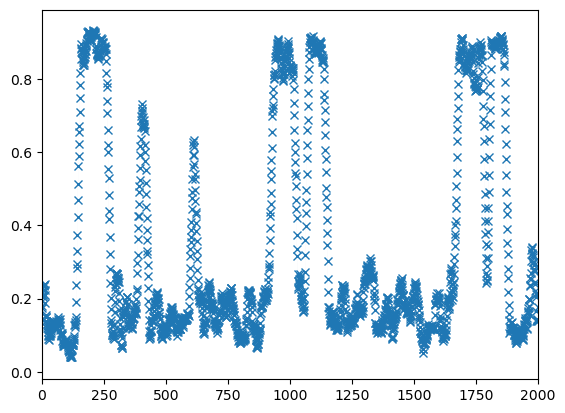

In [14]:
def smooth(data, window_size = 20):
    # Create a uniform window
    window = np.ones(window_size) / window_size

# Smooth the data
    smoothed_data = np.convolve(data, window, mode='valid')

    return smoothed_data




Q=1/(1+np.exp(10*(Traj_CA_Distnaces-(Native_Contact_Distances_nframes+1))))
Q_sum=np.sum(Q,axis=0)
Q_sum=np.sum(Q,axis=0)
Q=Q_sum/len(Native_CA_Distances)

Q_smooth  = smooth(Q)
plt.plot(Q_smooth,marker='x',linewidth=.01)
plt.xlim(0,2000)
plt.show()




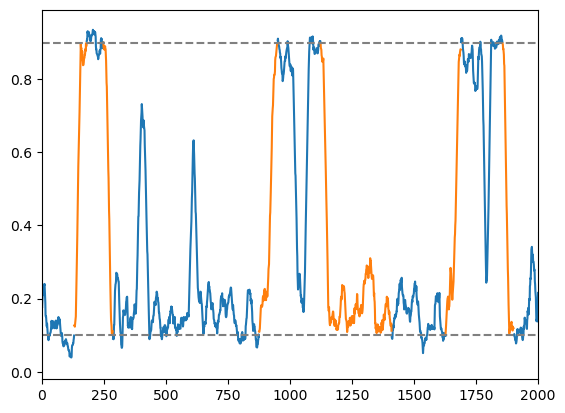

In [34]:
def assign_states(data, lower=0.1, upper=0.9):
    # define unfolded as 0; folded as 1
    state = []
    # assign the first frame arbitrarily with a state
    state.append(0)
    this_state = 0
    for q in data[1::]:
        
        if q < lower:
            this_state = 0
        elif q > upper:
            this_state = 1

        
        state.append(this_state)
    return np.array(state)

state_forward = assign_states(Q_smooth)

state_backward = assign_states(Q_smooth[::-1])[::-1]

transition_path = (state_forward != state_backward)

tran = np.ma.masked_where(transition_path,Q_smooth)
nontran = np.ma.masked_where(~transition_path,Q_smooth)

frame = range(len(transition_path))

plt.plot(frame, tran,frame,nontran)
plt.axhline(0.1,linestyle='--',color="grey")
plt.axhline(0.9,linestyle='--',color="grey")
plt.xlim(0,2000)
plt.show()
        


    

In [15]:
a=[12,3,4]
a[1::]

[3, 4]